In [218]:
import pandas as pd
#load data from csv
data = pd.read_csv(r"C:\Users\zhoum\star\python\playground\docs\used_car_train_20200313.csv",delimiter=" ")
print (data.shape)

(150000, 31)


0    33305
1    25996
2    23900
3    11345
4     8011
5     6092
6     5605
7      737
Name: bodyType, dtype: int64
0    73378
1    39467
2     1752
3      236
4      108
6       26
5       24
Name: fuelType, dtype: int64
0    87738
1    27253
Name: gearbox, dtype: int64
<bound method NDFrame.describe of 0         1850
1         6222
2         2400
3         5200
4         8000
          ... 
114986    5900
114987    9500
114988    7500
114989    4999
114990    4700
Name: price, Length: 114991, dtype: int64>


IndexError: index 0 is out of bounds for axis 0 with size 0

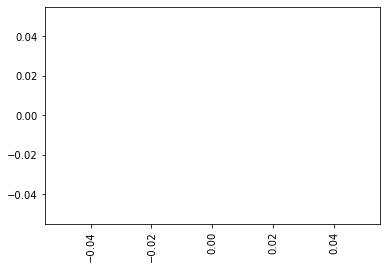

In [244]:
#feature preprocess

#after check hist, decide to remove NA
print(data["bodyType"].value_counts())
print(data["fuelType"].value_counts())
print(data["gearbox"].value_counts())
print(data['price'].describe)


# nan可视化
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

data.dropna(axis=0,how="any",inplace=True)
data.drop(data[data.notRepairedDamage=="-"].index,inplace=True)
data=data.reset_index(drop=True)
# convert float to int
data['notRepairedDamage'] = pd.to_numeric(data['notRepairedDamage'])
for col in ["model","bodyType","fuelType","gearbox",'notRepairedDamage',"used_time"]:
    data[col]=data[col].astype('int64')

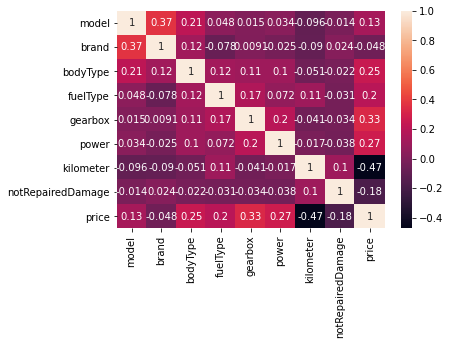

In [220]:
# feature selection
import seaborn as sns
import matplotlib.pyplot as plt

col_list=["model","brand","bodyType","fuelType","gearbox","power","kilometer","notRepairedDamage","price"]
corrMatrix=data[col_list].corr()
sns.heatmap(corrMatrix, annot=True)


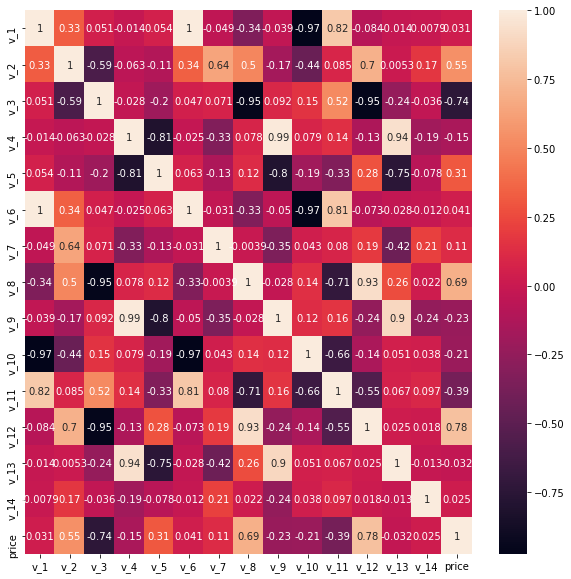

In [157]:
plt.figure(figsize=(10, 10))
col_list_2=["v_1","v_2","v_3","v_4","v_5","v_6","v_7","v_8","v_9","v_10","v_11","v_12","v_13","v_14","price"]
corrMatrix_2=data[col_list_2].corr()
sns.heatmap(corrMatrix_2, annot=True)
plt.show()

count    118326.000000
mean        127.252430
std         156.483912
min           0.000000
25%          80.000000
50%         116.000000
75%         155.000000
max       17700.000000
Name: power, dtype: float64


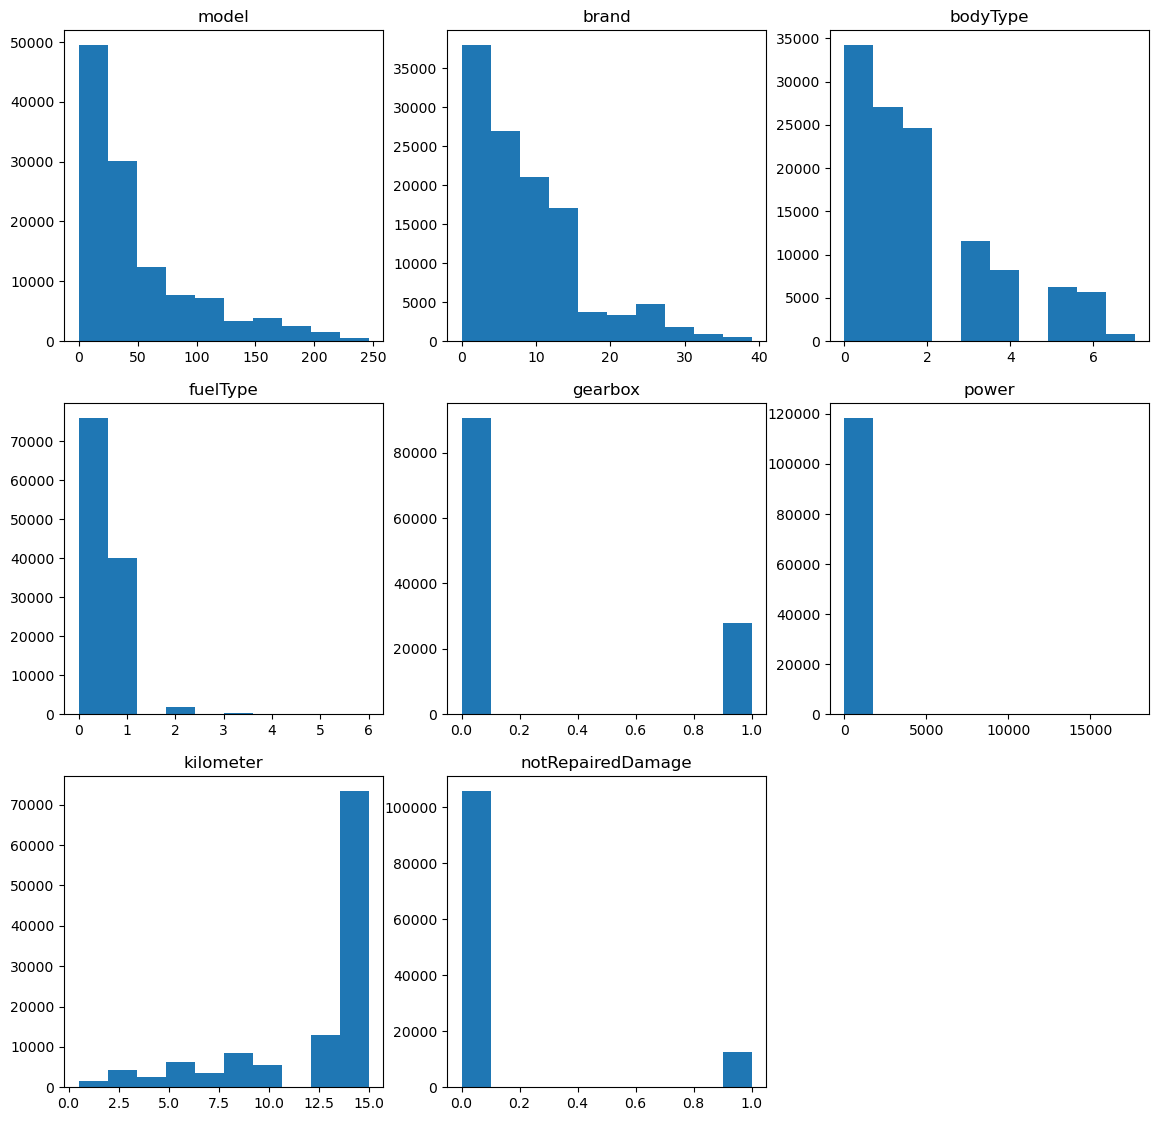

In [158]:
plt.figure(figsize=(14,14),dpi=100)
cols=["model","brand","bodyType","fuelType","gearbox","power","kilometer","notRepairedDamage"]
print(data["power"].describe())
for col in cols:
    plt.subplot(3,3,cols.index(col)+1)
    plt.hist(data[col])
    plt.title(col)



In [221]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score, make_scorer
import numpy as np
# select out valid features

exclude_columns = ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']
category_features = ["model","bodyType","fuelType","gearbox","notRepairedDamage"]
#data_after_onehot=pd.get_dummies(data,columns=category_features)
features = [feature for feature in data.columns.tolist() if feature not in exclude_columns ]

x = data[features] 
y = np.log(data["price"]+1)

#probably used future information, which will be revised later
x_train,x_test,y_train,y_test = train_test_split(x,y)
clf = LinearRegression(normalize=True)
clf.fit(x_train,y_train)
y_predict = clf.predict(x_test)
print(mean_absolute_error(y_test, y_predict))
print(r2_score(y_test,y_predict))
print(sorted(dict(zip(features, clf.coef_)).items(), key=lambda x:x[1], reverse=True))

0.19805831998167214
0.9314001519406834
[('v_11', 88207.76956771781), ('v_12', 16134.078196771767), ('v_3', 2216.9485427808877), ('v_5', 254.2608661784885), ('v_9', 72.00116876062019), ('v_7', 43.71724756868571), ('v_8', 27.704135988012496), ('v_13', 19.845528167116658), ('v_14', 0.35327320961945086), ('offerType', 0.09656516492175626), ('gearbox', 0.048773496288294395), ('fuelType', 0.001841787761806377), ('bodyType', 0.0017144825865143519), ('power', 0.00016737947286202628), ('used_time', 3.7887220757466434e-06), ('kilometer', -0.01068911532624321), ('notRepairedDamage', -0.26887540302820173), ('v_4', -2.9766368627827506), ('v_6', -184.64221100467546), ('v_0', -6267.0283999294525), ('v_2', -48417.65542380866), ('v_10', -115552.42820500242), ('v_1', -137854.98735245355)]


In [222]:
# include timeseries split
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train, test in tscv.split(data):
    x_train = data.iloc[train,][features]
    y_train = np.log(data.iloc[train,]["price"]+1)
    x_test = data.iloc[test,][features]
    y_test = np.log(data.iloc[test,]["price"]+1)
    clf.fit(x_train, y_train)
    y_predict=clf.predict(x_test)
    print(mean_absolute_error(y_test, y_predict))
    print(r2_score(y_test,y_predict))
    
    

0.19765383834120895
0.930964909258352
0.19858298624401302
0.9325509287198519
0.19622612835364875
0.9345377688629065
0.19577582592739612
0.933476778821326
0.19966693925982867
0.9302275531912301


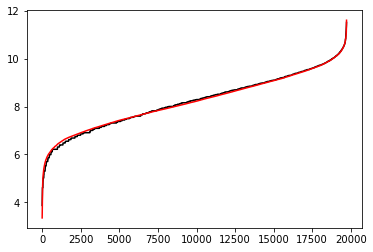

In [161]:
import matplotlib.pyplot as plt
plt.plot(range(len(y_test)),sorted(y_test.values),c="black",label= "y_test")
plt.plot(range(len(y_predict)),sorted(y_predict),c="red",label="y_predict")

In [235]:
# test on testb data
testB = pd.read_csv(r"C:\Users\zhoum\star\python\playground\docs\used_car_testB_20200421.csv",delimiter=" ")

In [224]:
# use ridge,lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

models = [Ridge(),Lasso()]
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, x,y,cv= 5,scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

Ridge is finished
Lasso is finished


,Ridge,Lasso
cv1,0.199360,0.526872
cv2,0.201985,0.515431
cv3,0.201824,0.532602
cv4,0.197831,0.522410
cv5,0.202652,0.521580


In [243]:
#use non-linear models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100)]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, x,y, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')
    
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished


c:\users\zhoum\star\python\playground\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\zhoum\star\python\playground\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\zhoum\star\python\playground\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs

MLPRegressor is finished


c:\users\zhoum\star\python\playground\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor
cv1,0.196410,0.188485,0.132922,0.173934,0.554426
cv2,0.198627,0.191937,0.135586,0.175418,0.506532
cv3,0.198855,0.191365,0.136131,0.175442,0.545545
cv4,0.194829,0.188571,0.132661,0.171576,0.878073
cv5,0.199858,0.190658,0.134765,0.176246,0.444882
